## Train / Validation Split

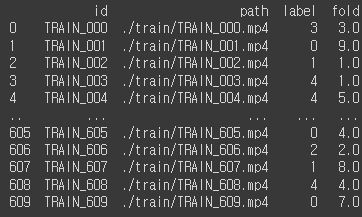

In [ ]:
# Stratified K-Folds cross-validator
from sklearn.model_selection import StratifiedKFold
# StratifiedKFold(n_splits, shuffle, random_state)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=CFG['SEED'])  # fold가 10개 만들어진다.

# train_index를 SKF로 검증하여 한 fold에 특정 val_index가 몰리지 않도록 한다.
# df를 skf.split()하면 'fold'열이 추가된다(초기값 0)
for n, (train_index, val_index) in enumerate(skf.split(df, df['label'])):   
    '''
    df에서 val_index의 fold 값을 해당 fold index로 대체한다 
    -> SKF가 끝나면 각 train_index가 몇 번째 fold에서 val_index로 선정되었는지 알 수 있다. 
    '''
    df.loc[val_index, 'fold'] = int(n)  
df['fold'] = df['fold'].astype(int)     # dataframe 내의 type 전체를 int로 바꾼다.
'''

.reset_index(drop=True): 해당 열을 버린다.

df['fold'] == 0: train_index
df['fold'] != 0: val_index
'''
train = df[df['fold'] != 0].reset_index(drop=True)
val = df[df['fold'] == 0].reset_index(drop=True)

## Class Weights

In [ ]:
labels = []
for i in df['label']:
    labels.append(i)
labels.sort()   # label을 오름 차순 정렬


'''
# 각 class를 빈도수에 따라 다른 weight를 할당한다.

# 빈도수가 큰 class에 weight를 적게 할당한다.
# 빈도수가 작은 class에 weight를 크게 할당한다.

compute_class_weight(class_weight, classes, y)
class_weight: balanced -> n_samples/(n_classes * np.bincount(y))
'''

# np.unique(list/numpy array) -> 1차원 shape로 변환하고, 정렬을 진행한 결과를 반환한다.
# np.bincount() -> array 내에서의 각 값의 빈도수를 반환한다.

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes=np.unique(labels), y=labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# Model Define(first method)
class model 내에서 backbone 선언과 feature extraction을 한번에 수행

In [ ]:
from torchvision.models.video import r3d_18

class BaseModel(nn.Module):
    def __init__(self, num_classes=5):
        super(BaseModel, self).__init__()
        self.model1 = r3d_18(weights='KINETICS400_V1')
        self.feature_extractor = nn.Sequential(
            '''
            KINETICS400 dataset은 400개의 클래스를 가지므로
            KINETICS400 dataset으로 pre-trained 되어 있는 3d resnet의
            output feature 수는 400이다.
            ''' 
            nn.Linear(400, 200),    
            nn.ReLU(),
            nn.Linear(200, num_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.model1(x)
        x = self.feature_extractor(x)
        return x

# Model Define(second method)
model을 load한 후, 추가로 feature extraction

In [ ]:
'''
import torch.vision as models
model = models.video.r3d_18(pretrained=bool)
num_ftrs = model_ft.fc.in_features  # model의 output feature 수
model.fc = nn.Linear(num_ftrs, len (class_names))   # model의 fc layer를 원하는 layer로 변경
'''
model = models.video.r3d_18(pretrained=True) # https://pytorch.org/vision/0.8/models.html
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)